In [1]:
import test_config as cfg
import numpy as np

import sys, os, os.path, time, datetime
import pickle, io, json

import skimage, skimage.io, skimage.transform, skimage.filters
import sklearn, sklearn.metrics

import importlib
sys.path.append('../src/')
import modutils
import word_processing as wp
import htr_model as hm
import tqdm
import tensorflow as tf
import editdistance

In [2]:
class BaseTransformer:
    def __init__(self):
        pass
    def transform(self, x):
        return x

    
class SequentialTransformer:
    def __init__(self, *args):
        self.stages_ = args
        
    def transform(self, x):
        res = x
        for s in self.stages_:
            res = s.transform(res)
        return res
    
class LoadImageTransformer(BaseTransformer):
    def __init__(self, path):
        self.path_ = path
        
    def transform(self, x):
        if type(x) != str:
            raise Exception("LoadImageTransformer: expects filename as argument!")
        return skimage.io.imread(os.path.join(self.path_, x), as_grey=True)
    
class ConvertFloatTransformer(BaseTransformer):
    def __init__(self, min_value = 0.0, max_value = 1.0):
        self.min_ = min_value
        self.max_ = max_value
        
    def transform(self, x):
        if x.dtype in (np.float, np.float64, np.float32):
            return x
        if x.dtype == np.uint8:
            return (x / 255.0) * (self.max_ - self.min_) + self.min_
        if x.dtype == np.uint16:
            return (x / 65535.0) * (self.max_ - self.min_) + self.min_
        raise Exception("ConvertFloatTransformer: unexpected argument type!")
    
class RandomStretchTransformer(BaseTransformer):
    def __init__(self, min_scale = 0.66, max_scale = 1.5, fill_value=1.0):
        self.max_ = max_scale
        self.min_ = min_scale
        self.fill_ = fill_value
        
    def transform(self, x):
        f = np.random.uniform(self.min_, self.max_)
        return skimage.transform.rescale(x, (1.0, f), mode='constant', cval=self.fill_)
    
class TransposeTransformer(BaseTransformer):
    def __init__(self):
        pass
    def transform(self, x):
        return np.transpose(x)
    
class FitSizeTransformer(BaseTransformer):
    def __init__(self, width, height, fill_value=1.0):
        self.w_ = width
        self.h_ = height
        self.fill_ = fill_value
        self.template_ = np.ones((self.h_, self.w_)) * self.fill_
        
    def transform(self, x):
        (h, w) = x.shape
        f = max(w / self.w_, h / self.h_)
        res = self.template_.copy()
        rw = max(min(self.w_, int(w / f)), 1)
        rh = max(min(self.h_, int(h / f)), 1)
        res[0:rh, 0:rw] = skimage.transform.resize(x, (rh, rw), mode='constant', cval=self.fill_)
        return res
    
class StandardizeTransformer(BaseTransformer):
    def __init__(self):
        pass
    
    def transform(self, x):
        m = np.mean(x)
        s = np.std(x)
        if s <= 1e-9:
            return x - m
        return (x - m) / s
    
class TruncateLabelTransform(BaseTransformer):
    def __init__(self, max_cost):
        self.max_cost_ = max_cost
        
    def transform(self, x):
        if type(x) != str:
            raise Exception("TruncateLabelTransform: input expected to be of type string!")
        cost = 0
        for i in range(len(x)):
            flg = (i > 0) and (x[i] == x[i-1])
            cost += 1 + int(flg)
            if cost > max_cost:
                return x[:i]
        return x

In [3]:
with open('D:/models/htr-static-128/model_info.json', 'r') as fp:
    model_info = json.load(fp)

In [4]:
transform_pipeline = SequentialTransformer(
    FitSizeTransformer(128, 32),
    TransposeTransformer(),
    StandardizeTransformer())

In [5]:
%%time
fname = 'D:/Data/bujo_sample_v2/dataset.json'
extraction_path = os.path.join(os.path.dirname(fname),
                               os.path.basename(fname).split('.')[0])
with open(fname, 'r', encoding='utf-8') as f:
    src = json.load(f)
    
words = wp.extract_words_from_dataset(src, (1,))

transforms = [{'cutoff': 0.7, 'type': 'cutoff'},
  {'type': 'trimx'}, {'type': 'trimy'},
  {'type': 'resize', 'y': 32}, {'type': 'invert'}]

raw_lbls = [x[0] for x in words]

def load_images(path, words, transform):
    res = []
    for (i, (word, fname)) in enumerate(tqdm.tqdm(words)):
        src_image = skimage.io.imread(os.path.join(path, fname), as_grey=True)
        res_image = wp.perform_transform(src_image, transform)
        res.append(res_image)
    return res

Wall time: 74.4 ms


In [6]:
raw_imgs = load_images('D:/Data/bujo_sample_v2/dataset/', words, transforms)

  0%|                                                                                         | 0/1579 [00:00<?, ?it/s]C:\Anaconda3\lib\site-packages\skimage\io\_io.py:49: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')
C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [00:24<00:00, 64.56it/s]


In [7]:
tflite_fname = 'D:/models/htr-static-128/model.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_fname)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [8]:
input_details

[{'name': 'in_image',
  'index': 24,
  'shape': array([  1, 128,  32]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)}]

In [9]:
output_details

[{'name': 'out_rnn',
  'index': 25,
  'shape': array([  1,  32, 102]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)}]

In [10]:
def run_inference(tfi, input_info, output_id, img, pipeline=BaseTransformer()):
    data = pipeline.transform(img).reshape(input_info['shape']).astype(input_info['dtype'])
    tfi.set_tensor(input_info['index'], data)
    tfi.invoke()
    return tfi.get_tensor(output_id)

In [32]:
%%time
res = []
for img in tqdm.tqdm(raw_imgs):
    res.append(run_inference(interpreter, input_details[0], output_details[0]['index'], img, transform_pipeline))

  0%|                                                                                         | 0/1579 [00:00<?, ?it/s]C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [00:17<00:00, 90.79it/s]


Wall time: 17.4 s


In [33]:
tflite_raw_out = np.vstack(res)

In [34]:
tflite_raw_out.shape

(1579, 32, 102)

In [34]:
with open('D:/models/htr-static-128/tf-out.pkl', 'rb') as f:
    tf_raw_out = pickle.load(f)

In [35]:
tf_raw_out.shape

(1579, 32, 102)

In [46]:
diff = tflite_raw_out - tf_raw_out

In [49]:
diff.mean()

-2.1687958e-09

In [50]:
abs(diff).mean()

1.4741873e-06

In [54]:
import matplotlib.pyplot as plt

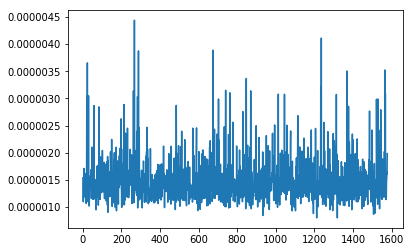

In [55]:
plt.plot(abs(diff).mean(axis=(1,2)))

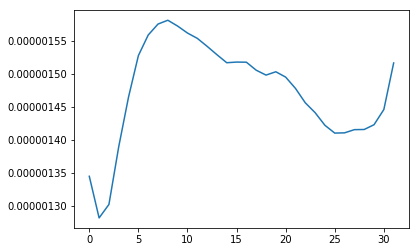

In [56]:
plt.plot(abs(diff).mean(axis=(0,2)))

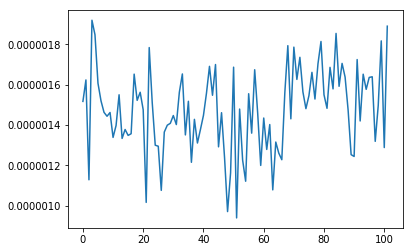

In [58]:
plt.plot(abs(diff).mean(axis=(0,1)))

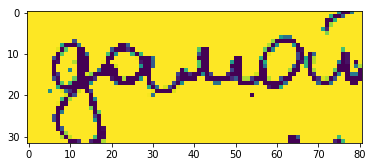

In [59]:
plt.imshow(raw_imgs[4])

In [11]:
prep_img = transform_pipeline.transform(raw_imgs[4])

In [31]:
prep_img[-4]

array([0.31645951, 0.31645951, 0.31645951, 0.31645951, 0.31645951,
       0.31645951, 0.31645951, 0.31645951, 0.31645951, 0.31645951,
       0.31645951, 0.31645951, 0.31645951, 0.31645951, 0.31645951,
       0.31645951, 0.31645951, 0.31645951, 0.31645951, 0.31645951,
       0.31645951, 0.31645951, 0.31645951, 0.31645951, 0.31645951,
       0.31645951, 0.31645951, 0.31645951, 0.31645951, 0.31645951,
       0.31645951, 0.31645951])

In [80]:
prep_txt = '\n'.join([','.join(['{:.3f}'.format(x) for x in row]) for row in prep_img])

In [81]:
with open('D:/htr_test.csv', 'w') as f:
    f.write(prep_txt)

In [82]:
with open('D:/htr_test.csv', 'r') as f:
    tmp = f.readlines()

In [100]:
tmp2 = np.array([[float(z) for z in x.strip().split(',')] for x in tmp], dtype=np.float32).reshape(1,128,32)

In [101]:
tmp2.shape

(1, 128, 32)

In [102]:
interpreter.set_tensor(24, tmp2)
interpreter.invoke()
tmp3 = interpreter.get_tensor(25)

In [103]:
tmp3

array([[[-4.876584  , -4.230886  ,  0.9705517 , ..., -2.5995126 ,
          0.7614088 ,  5.0094614 ],
        [-7.0142446 , -4.421624  , -0.7334287 , ..., -7.2850013 ,
         -0.84496796, 14.243643  ],
        [-7.7787848 , -5.2862854 , -1.4064631 , ..., -8.142427  ,
         -1.1320279 , 17.465988  ],
        ...,
        [-0.3206597 ,  1.8268558 , -0.19786823, ...,  2.8740923 ,
         -1.5703324 , 22.429377  ],
        [-0.07465783,  1.7670895 , -0.03736232, ...,  3.2165701 ,
         -1.4797934 , 22.140074  ],
        [ 0.47041738,  1.8316121 ,  0.14334652, ...,  4.1674924 ,
         -1.3379502 , 20.868961  ]]], dtype=float32)

In [105]:
tflite_raw_out[4].shape

(32, 102)

In [8]:
words[4]

('дамой', '20190520_232221/line02_word05.jpg')

In [9]:
raw_imgs[4]

array([[1.       , 1.       , 1.       , ..., 0.4058642, 1.       ,
        1.       ],
       [1.       , 1.       , 1.       , ..., 1.       , 1.       ,
        1.       ],
       [1.       , 1.       , 1.       , ..., 1.       , 1.       ,
        1.       ],
       ...,
       [1.       , 1.       , 1.       , ..., 1.       , 1.       ,
        1.       ],
       [1.       , 1.       , 1.       , ..., 1.       , 1.       ,
        1.       ],
       [1.       , 1.       , 1.       , ..., 1.       , 1.       ,
        1.       ]])

In [17]:
tmp0 = skimage.io.imread('D:/Data/bujo_sample_v2/dataset/20190520_232221/line02_word05.jpg', as_grey=True)

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:49: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


In [38]:
open('D:/models/htr-static-128/model.chars', 'w').write(model_info['chars'])

101

In [19]:
wp.trim_image_width(tmp0).shape

(104, 298)

In [20]:
wp.trim_image_height(tmp0).shape

(104, 298)

In [21]:
tmp1 = wp.perform_transform(tmp0, [{'cutoff': 0.7, 'type': 'cutoff'}, {'type': 'trimx'}, {'type': 'trimy'}])

In [22]:
tmp1.shape

(104, 265)

In [23]:
raw_imgs[4]

array([[1.       , 1.       , 1.       , ..., 0.4058642, 1.       ,
        1.       ],
       [1.       , 1.       , 1.       , ..., 1.       , 1.       ,
        1.       ],
       [1.       , 1.       , 1.       , ..., 1.       , 1.       ,
        1.       ],
       ...,
       [1.       , 1.       , 1.       , ..., 1.       , 1.       ,
        1.       ],
       [1.       , 1.       , 1.       , ..., 1.       , 1.       ,
        1.       ],
       [1.       , 1.       , 1.       , ..., 1.       , 1.       ,
        1.       ]])

In [35]:
tflite_raw_out[4]

array([[-4.878003  , -4.2308526 ,  0.9700881 , ..., -2.600423  ,
         0.76062745,  5.008127  ],
       [-7.014785  , -4.42105   , -0.7335675 , ..., -7.286478  ,
        -0.8457819 , 14.244612  ],
       [-7.7779045 , -5.285049  , -1.4053832 , ..., -8.143538  ,
        -1.1338047 , 17.467548  ],
       ...,
       [-0.32135502,  1.8284191 , -0.19872187, ...,  2.8718238 ,
        -1.570783  , 22.431046  ],
       [-0.07570744,  1.7681125 , -0.03827469, ...,  3.2137828 ,
        -1.4802605 , 22.142618  ],
       [ 0.46903688,  1.83247   ,  0.14169806, ...,  4.164313  ,
        -1.3381999 , 20.872272  ]], dtype=float32)